<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/improvement_Lucia/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b improvement_Lucia https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 2468 (delta 20), reused 0 (delta 0), pack-reused 2431
Receiving objects: 100% (2468/2468), 2.74 MiB | 2.29 MiB/s, done.
Resolving deltas: 100% (1582/1582), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Datasets

In [5]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [7]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [8]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [9]:
BIC = ResNet.BiasLayer()

In [10]:
exemplars = [None]*100

test_indexes =  []
accs = []

In [11]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
  test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE , shuffle=True )
  
  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars, train_transformer, BIC = BIC)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
    img = img.float().to(params.DEVICE)
    lbl = lbl.to(params.DEVICE)
    outputs = ICaRL(img)
    c = np.array(train_splits[int(task/10)]).astype(int)
    cut_outputs = np.take_along_axis(outputs.to(params.DEVICE), c[None,:], axis = 1).to(params.DEVICE)
    cut_outputs = BIC(cut_outputs)
    outputs[:,c] = cut_outputs
    
    _ , preds = torch.max(outputs.data, 1)
    #labels = utils.mapFunction(lbl, col).to(params.DEVICE)
    total += len(lbl)
    running_corrects += torch.sum(preds == lbl.data).data.item()
  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')
  accs.append(accuracy)

  total = 0.0
  running_corrects = 0.0
  #tot_preds = []
  #tot_lab = []
  for img, lbl, _ in test_loader:
    img = img.float().to(params.DEVICE)
    lbl = lbl.to(params.DEVICE)
    outputs = ICaRL(img)
    c = np.array(train_splits[int(task/10)]).astype(int)
    cut_outputs = np.take_along_axis(outputs.to(params.DEVICE), c[None,:], axis = 1).to(params.DEVICE)
    cut_outputs = BIC(cut_outputs)
    outputs[:,c] = cut_outputs

    _ , preds = torch.max(outputs.data, 1)
    
    total += len(lbl)
    running_corrects += torch.sum(preds == lbl.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')
  #cf = confusion_matrix(tot_lab, tot_preds)
  #df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  #sn.set(font_scale = .5) # for label size
  #sn.heatmap(df_cm, annot=False)
  #plt.show()

task : 0
1.0 0.0
At step  0  and at epoch =  0  the loss is =  0.023228462785482407  and accuracy is =  0.1836
At step  0  and at epoch =  1  the loss is =  0.02203056775033474  and accuracy is =  0.3716
At step  0  and at epoch =  2  the loss is =  0.02631252259016037  and accuracy is =  0.441
At step  0  and at epoch =  3  the loss is =  0.02978803589940071  and accuracy is =  0.5206
At step  0  and at epoch =  4  the loss is =  0.027100667357444763  and accuracy is =  0.5506
At step  0  and at epoch =  5  the loss is =  0.0311138816177845  and accuracy is =  0.5634
At step  0  and at epoch =  6  the loss is =  0.0290700551122427  and accuracy is =  0.6164
At step  0  and at epoch =  7  the loss is =  0.017687682062387466  and accuracy is =  0.629
At step  0  and at epoch =  8  the loss is =  0.01771804690361023  and accuracy is =  0.6842
At step  0  and at epoch =  9  the loss is =  0.0234511848539114  and accuracy is =  0.6766
At step  0  and at epoch =  10  the loss is =  0.029441

In [12]:
accs = [.89,.76,.71,.64,.59,.53,.48,.45,.41,.40, .38]

In [13]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def plotTask(pars_tasks):

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy'])
  plt.xlabel("Epoch")
  plt.ylim(0,1)
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy'])
  plt.grid(True)
  plt.show()

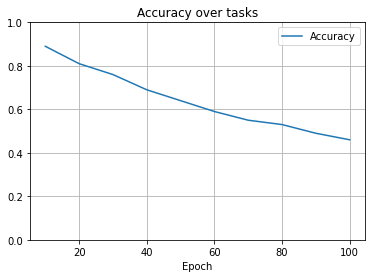

In [14]:
plotTask(accs)